<a href="https://colab.research.google.com/github/FritzAriza/TDG_Ariza_Roman/blob/main/Red_CNN_TG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%pip install tensorflow_io

In [47]:
# Importación de bibliotecas
import os
import shutil
import pathlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

from pathlib import Path
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [48]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Funciones auxiliares para la carga y procesamiento de audio
def load_audio(file_path):
    sample_rate = 16000
    channels = 1
    audio_binary = tf.io.read_file(file_path)
    try:
        audio, original_sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=channels)
        audio = tf.cast(audio, tf.float32)
        audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
        waveform = tf.squeeze(audio, axis=-1)
        return waveform, sample_rate
    except tf.errors.InvalidArgumentError as e:
        print(f"Error al decodificar {file_path}: {e}")
        return None, None

def load_audio_files(path: str, label: str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        parts = speaker.split("_")
        # Verificar si el nombre del archivo tiene el formato esperado
        if len(parts) == 4:
            command, noise_level, _, speaker_id = parts
        else:
            print(f"Omitiendo archivo con nombre inesperado: {filename}")
            continue
        # Verificar si el comando coincide con la etiqueta de la carpeta
        if command != label:
            print(f"Omitiendo archivo con comando incorrecto: {filename}")
            continue
        # Cargar el audio
        waveform, sample_rate = load_audio(file_path)
        if waveform is None:
            continue
        # Agregar la información al conjunto de datos
        dataset.append([waveform, sample_rate, label, noise_level, speaker_id])

    return dataset

warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_spectrogram(waveform):
    # Calcula el relleno solo si la forma de onda tiene menos de 8000 muestras
    target_length = 8000
    waveform_length = tf.shape(waveform)[0]
    padding_length = tf.maximum(0, target_length - waveform_length)# Calcula la longitud del relleno asegurando que no sea negativo
    zero_padding = tf.zeros([padding_length], dtype=tf.float32)

    # Concatena el audio con el relleno para que todos los clips de audio tengan la misma longitud
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    # Crea el espectrograma
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

def create_images(dataset, label_dir):
    # creando las carpetas
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    # Limpiar las carpetas si ya existen
    if os.path.exists(test_directory):
        shutil.rmtree(test_directory)
    if os.path.exists(train_directory):
        shutil.rmtree(train_directory)

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):
        waveform = data[0]
        spectrogram= get_spectrogram(waveform)
        # Dividir las imágenes de prueba (15%) y entrenamiento con validacion (85%)
        if ((i % 7 == 0) or (i % 128 == 0)):
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')

        # Contar archivos en las carpetas
    test_count = len(os.listdir(test_directory))
    train_count = len(os.listdir(train_directory))

    print('--------------------------------------------')
    print(f'Longitud del conjunto de datos {label_dir}')
    print(f"Archivos de entranamiento: {train_count}")
    print(f"Archivos de prueba: {test_count}")

def plot_spectrogram(spectrogram, ax, title):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)

In [50]:
data_dir = pathlib.Path('/content/drive')

In [51]:
trainset_abre = load_audio_files('/content/drive/MyDrive/dataset/dataset/abre', 'abre')
trainset_apaga = load_audio_files('/content/drive/MyDrive/dataset/dataset/apaga', 'apaga')
trainset_cierra = load_audio_files('/content/drive/MyDrive/dataset/dataset/cierra', 'cierra')
trainset_dime = load_audio_files('/content/drive/MyDrive/dataset/dataset/dime', 'dime')
trainset_enciende = load_audio_files('/content/drive/MyDrive/dataset/dataset/enciende', 'enciende')

print(f'Longitud del conjunto de datos abre: {len(trainset_abre)}')
print(f'Longitud del conjunto de datos apaga: {len(trainset_apaga)}')
print(f'Longitud del conjunto de datos cierra: {len(trainset_cierra)}')
print(f'Longitud del conjunto de datos dime: {len(trainset_dime)}')
print(f'Longitud del conjunto de datos enciende: {len(trainset_enciende)}')

Longitud del conjunto de datos abre: 258
Longitud del conjunto de datos apaga: 258
Longitud del conjunto de datos cierra: 258
Longitud del conjunto de datos dime: 258
Longitud del conjunto de datos enciende: 258


In [52]:
create_images(trainset_abre, 'abre')
create_images(trainset_apaga, 'apaga')
create_images(trainset_cierra, 'cierra')
create_images(trainset_dime, 'dime')
create_images(trainset_enciende, 'enciende')

--------------------------------------------
Longitud del conjunto de datos abre
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos apaga
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos cierra
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos dime
Archivos de entranamiento: 219
Archivos de prueba: 39
--------------------------------------------
Longitud del conjunto de datos enciende
Archivos de entranamiento: 219
Archivos de prueba: 39


In [53]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=None, subset=None)#color_mode='grayscale'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None, shuffle=False)#color_mode='grayscale'

class_names = train_ds.class_names
print(class_names)

Found 1095 files belonging to 5 classes.
Found 195 files belonging to 5 classes.
['abre', 'apaga', 'cierra', 'dime', 'enciende']


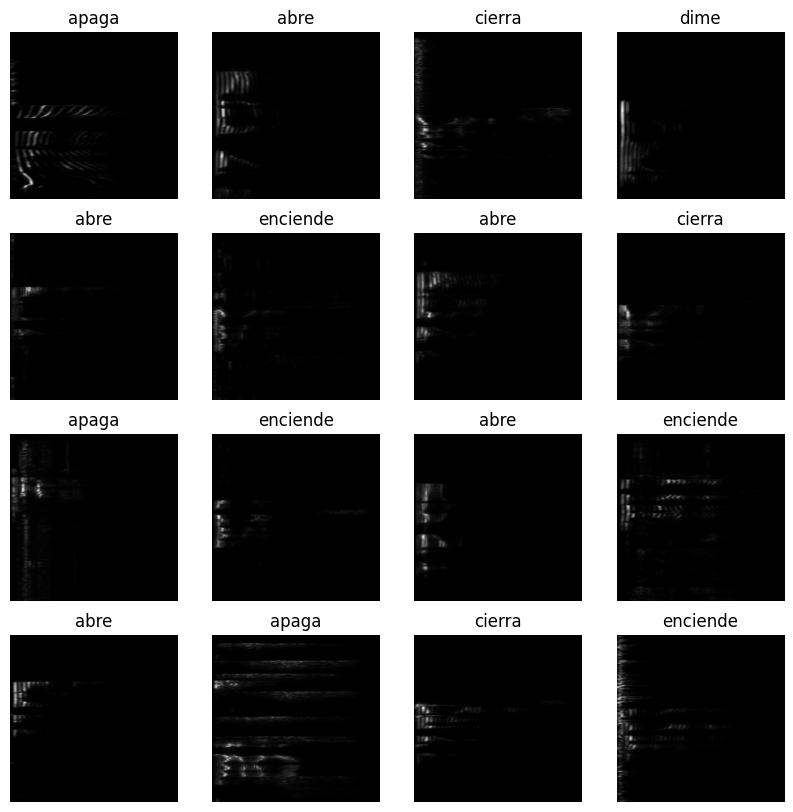

In [54]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [56]:
num_classes = 5
img_height = 256
img_width = 256

initializer = tf.keras.initializers.HeNormal()
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(256, 256, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes) # no es necesario softmax, porque la indicación from_logits=true ya lo usa
])

In [57]:
# Establecer el learning_rate, la función loss_fn, el optimizador y las métricas.
learning_rate = 0.0001
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [ ]:
# Creación de callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoriza la pérdida de validación
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaura los mejores pesos encontrados
)

model_checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.keras',  # Ruta para guardar el modelo
    monitor='val_accuracy',      # Monitoriza la precisión de validación
    save_best_only=True         # Guarda solo el mejor modelo
)

# Almacena class_names antes de dividir el conjunto de datos
class_names = train_ds.class_names

# Divide el conjunto de datos en conjuntos de entrenamiento y validación
validation_split = 0.1781
num_validation_samples = int(len(train_ds) * validation_split)
validation_ds = train_ds.take(num_validation_samples)
train_ds = train_ds.skip(num_validation_samples)

epochs = 100
print('\nFitting:')

# Entrenar el modelo
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[early_stopping, model_checkpoint])


Fitting:
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2417 - loss: 1.9102 - val_accuracy: 0.3073 - val_loss: 1.7201
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.3254 - loss: 1.6921 - val_accuracy: 0.4688 - val_loss: 1.6132
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3562 - loss: 1.5953 - val_accuracy: 0.4740 - val_loss: 1.5641
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4349 - loss: 1.4876 - val_accuracy: 0.5729 - val_loss: 1.4059
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.4782 - loss: 1.3770 - val_accuracy: 0.6302 - val_loss: 1.3382
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5247 - loss: 1.3181 - val_accuracy: 0.6302 - val_loss: 1.2539
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5630 - loss: 1.2171 - val_accuracy: 0.7188 - val_loss: 1.0902
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6399 - loss: 1.0707 - val_accuracy: 

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,814,801 (6.92 MB)

 Trainable params: 604,869 (2.31 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 1,209,740 (4.61 MB)

In [ ]:
# Evaluar el mejor modelo en el conjunto de datos de prueba
best_model = tf.keras.models.load_model('mejor_modelo.keras')
loss, accuracy = best_model.evaluate(test_ds)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 864ms/step - accuracy: 0.8700 - loss: 0.4427
Pérdida en el conjunto de prueba: 0.3968440890312195
Precisión en el conjunto de prueba: 0.9025641083717346


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Puntuación F1: 0.9025968087639914
Precisión: 0.9061390822260387
Recall: 0.9025641025641026
Accuracy: 0.9025641025641026


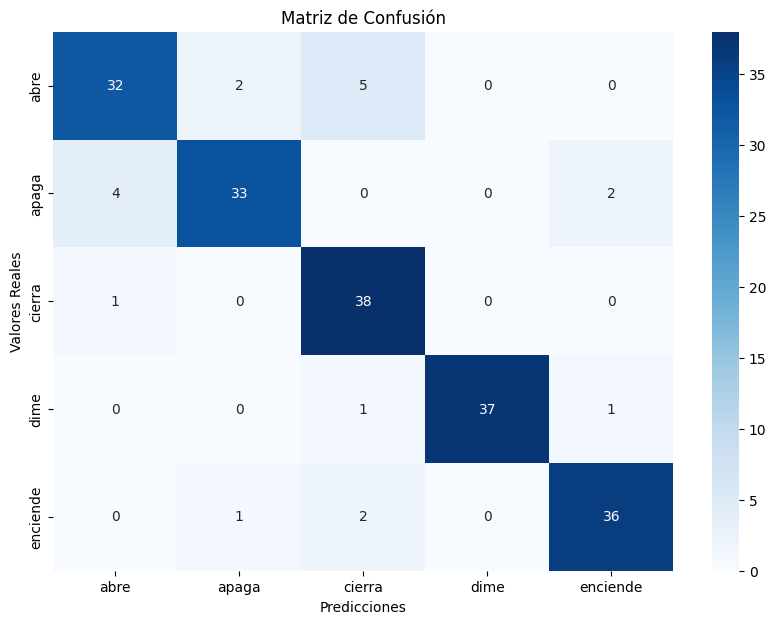

In [ ]:
# Extraer y_true antes de hacer predicciones
y_true = np.concatenate([y for _, y in test_ds.as_numpy_iterator()], axis=0)

# Luego, obtener las predicciones
y_pred_probs = best_model.predict(test_ds)  # Obtén las probabilidades de predicción
y_pred = np.argmax(y_pred_probs, axis=1) # Obtén las etiquetas predichas

# Calcular las métricas
f1 = f1_score(y_true, y_pred, average='macro')  # 'weighted' para promediar por clase
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred,average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Puntuación F1: {f1}")
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

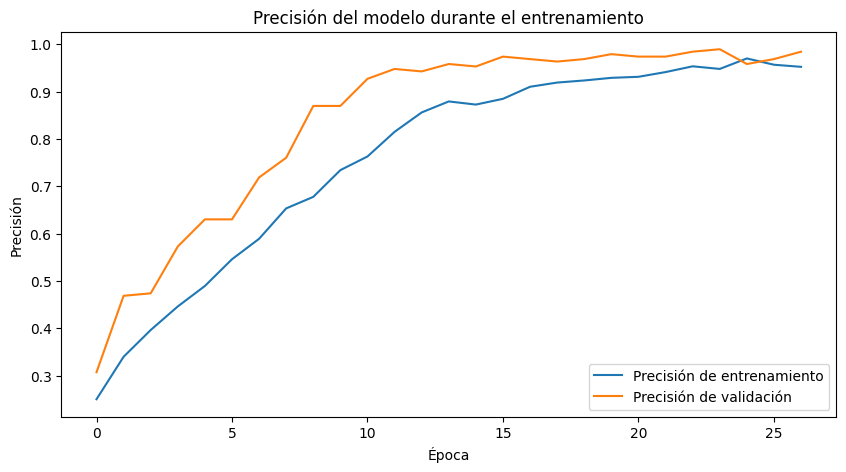

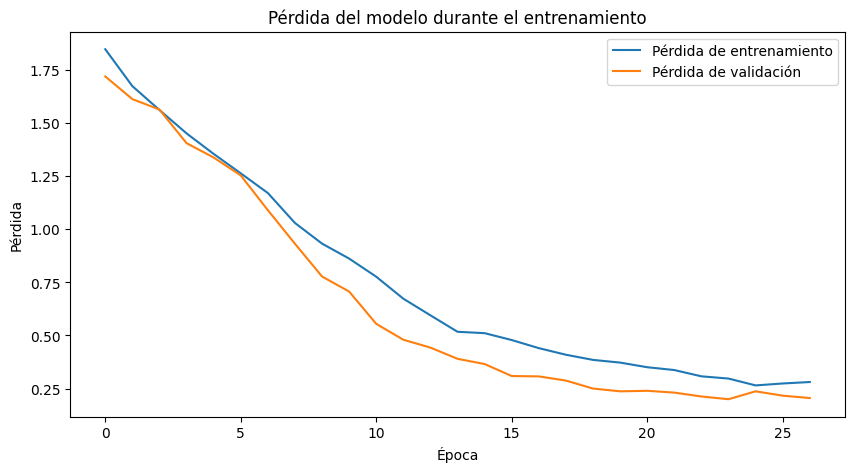

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#graficar el train accuracy y validation accuracy vs las épocas de entrenamiento
plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura si es necesario
plt.plot(training_accuracy, label='Precisión de entrenamiento')
plt.plot(validation_accuracy, label='Precisión de validación')
plt.title('Precisión del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

#graficar el train loss y validation loss vs las épocas de entrenamiento
plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura si es necesario
plt.plot(training_loss, label='Pérdida de entrenamiento')
plt.plot(validation_loss, label='Pérdida de validación')
plt.title('Pérdida del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()